In [1]:
# === Cell 1: Imports & config chung cho LightGBM NO2 ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except ImportError:
    print("Chưa cài lightgbm: !pip install lightgbm")

# Cấu hình chung
DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = ["211", "212", "213", "214", "215", "216"]

TARGET_COL = "NO2_quantrac"

# Các feature gốc dùng cho LightGBM (có thể thêm/bớt)
BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Các lag và rolling window dùng làm feature
LAG_STEPS = [1, 2, 3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24]

# Các horizon muốn dự báo (giờ)
#HORIZONS = [1, 2, 3, 4, 5, 24, 72]
HORIZONS = list(range(1, 73)) 

RANDOM_STATE = 42


In [2]:
# === Cell 2: Load & gộp dữ liệu từ các trạm ===

def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)
    
    # Chuẩn hóa cột thời gian
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    # Xoá cột index thừa nếu có
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    
    # Thêm thông tin trạm
    df["station_id"] = int(station_id)
    return df

dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

print("Kích thước dữ liệu gộp:", df_all.shape)
df_all.head()


Kích thước dữ liệu gộp: (92966, 15)


,date,TSP_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,NO2_quantrac,Temperature_quantrac,Humid_quantrac,PM25_cmaq,PM10_cmaq,O3_cmaq,SO2_cmaq,PM25_vientham,station_id,SO2_quantrac
0,2021-02-23 21:00:00,32.935714,15.604762,55.431381,90.000000,112.740762,28.361905,63.188095,NaN,NaN,NaN,NaN,NaN,211,NaN
1,2021-02-23 22:00:00,30.932353,14.594118,58.197176,1200.603529,112.366471,28.320588,63.773529,NaN,NaN,NaN,NaN,NaN,211,NaN
2,2021-02-23 23:00:00,27.645000,13.436667,55.029433,1177.897000,112.700433,28.336667,64.205000,NaN,NaN,NaN,NaN,NaN,211,NaN
3,2021-02-24 00:00:00,24.380000,12.365000,54.767700,90.000000,112.480867,28.305000,64.735000,NaN,NaN,NaN,NaN,NaN,211,NaN
4,2021-02-24 01:00:00,22.521667,11.636667,53.786200,90.000000,114.331500,28.300000,65.188333,NaN,NaN,NaN,NaN,NaN,211,NaN


In [3]:
# === Cell 3: Hàm tạo feature thời gian, lag, rolling ===

def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])
    
    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

def add_rolling_features(df, group_col, target_cols, windows):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])
    
    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1)              # dùng quá khứ, tránh leak
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Áp dụng feature engineering
df_feat = add_time_features(df_all)
df_feat = add_lag_features(df_feat, group_col="station_id",
                           target_cols=BASE_FEATURE_COLS,
                           lag_steps=LAG_STEPS)
df_feat = add_rolling_features(df_feat, group_col="station_id",
                               target_cols=[TARGET_COL],
                               windows=ROLL_WINDOWS)

print("Sau khi thêm feature:", df_feat.shape)
df_feat.head()


Sau khi thêm feature: (92966, 82)


,date,TSP_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,NO2_quantrac,Temperature_quantrac,Humid_quantrac,PM25_cmaq,PM10_cmaq,...,Humid_quantrac_lag48,Humid_quantrac_lag72,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2021-02-23 21:00:00,32.935714,15.604762,55.431381,90.000000,112.740762,28.361905,63.188095,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-23 22:00:00,30.932353,14.594118,58.197176,1200.603529,112.366471,28.320588,63.773529,NaN,NaN,...,NaN,NaN,112.740762,NaN,112.740762,NaN,112.740762,NaN,112.740762,NaN
2,2021-02-23 23:00:00,27.645000,13.436667,55.029433,1177.897000,112.700433,28.336667,64.205000,NaN,NaN,...,NaN,NaN,112.553616,0.264664,112.553616,0.264664,112.553616,0.264664,112.553616,0.264664
3,2021-02-24 00:00:00,24.380000,12.365000,54.767700,90.000000,112.480867,28.305000,64.735000,NaN,NaN,...,NaN,NaN,112.602555,0.205447,112.602555,0.205447,112.602555,0.205447,112.602555,0.205447
4,2021-02-24 01:00:00,22.521667,11.636667,53.786200,90.000000,114.331500,28.300000,65.188333,NaN,NaN,...,NaN,NaN,112.515924,0.169719,112.572133,0.178441,112.572133,0.178441,112.572133,0.178441


In [4]:
# === Cell 4: Tạo dataset supervised cho 1 horizon — FIX trùng station_id ===

def build_supervised_for_horizon(df, horizon_h, target_col=TARGET_COL):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])
    
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    
    # Mục tiêu: NO2 tại tương lai t+h
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)
    
    # Các cột không dùng làm feature
    ignore_cols = ["date", target_col, target_name]
    feature_cols = [c for c in df.columns if c not in ignore_cols]
    
    # Loại trùng tên cột (nếu có)
    feature_cols = list(dict.fromkeys(feature_cols))
    
    # KHÔNG cho station_id vào feature, chỉ giữ trong meta
    feature_cols_no_sid = [c for c in feature_cols if c != "station_id"]
    
    # data chỉ có 1 cột station_id (ở phần meta)
    data = df[["date", "station_id"] + feature_cols_no_sid + [target_name]].dropna()
    
    X = data[feature_cols_no_sid]
    y = data[target_name]
    meta = data[["date", "station_id"]]
    
    return X, y, meta, feature_cols_no_sid


# Ví dụ test cho horizon = 1
X_h1, y_h1, meta_h1, feat_cols = build_supervised_for_horizon(df_feat, horizon_h=1)
print("Horizon 1h:", X_h1.shape, y_h1.shape)


Horizon 1h: (5416, 79) (5416,)


In [5]:
# === Cell 5: Hàm split train/val/test theo thời gian ===

def time_based_split(X, y, meta,
                     train_ratio=0.7,
                     val_ratio=0.15):
    """
    Chia theo thứ tự thời gian (sau khi đã sort).
    """
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    meta_train = meta.iloc[:train_end]
    
    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    meta_val = meta.iloc[train_end:val_end]
    
    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    meta_test = meta.iloc[val_end:]
    
    return (X_train, y_train, meta_train,
            X_val, y_val, meta_val,
            X_test, y_test, meta_test)


In [6]:
# === Cell 6: Metrics cho NO2 ===

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)
    
    # MNBE (%) ~ giống chị dùng: trung bình (pred-true)/true * 100
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0
    
    # Pearson r (có kiểm tra độ lệch chuẩn)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true, y_pred)[0, 1]
    
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }


In [7]:
# === Cell 7: Train LightGBM cho 1 horizon — bản đơn giản, sạch lỗi ===

def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col=TARGET_COL,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y, meta, feature_cols = build_supervised_for_horizon(
        df_feat, horizon_h=horizon_h, target_col=target_col
    )
    
    # Chia train/val/test theo thời gian
    (X_train, y_train, meta_train,
     X_val, y_val, meta_val,
     X_test, y_test, meta_test) = time_based_split(X, y, meta)
    
    # KHÔNG xử lý station_id nữa, để nguyên dtype hiện tại
    # Nếu muốn chắc ăn có thể ép toàn bộ về float:
    # X_train = X_train.astype(float)
    # X_val   = X_val.astype(float)
    # X_test  = X_test.astype(float)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }
    
    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )
    
    # Dự báo trên tập test
    y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    metrics_overall = compute_metrics(y_test, y_test_pred)
    
    # Metrics theo từng trạm
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_test_pred
    
    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({
            "station": int(sid),
            "horizon_h": horizon_h,
            **m,
        })
    metrics_by_station = pd.DataFrame(rows)
    
    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )





In [8]:
# === Cell 8: Train cho nhiều horizon & tổng hợp metrics ===

all_metrics = []
models_by_h = {}

for h in HORIZONS:
    print(f"\n===== Training LightGBM cho horizon = {h}h =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(
        df_feat, horizon_h=h
    )
    models_by_h[h] = model_h
    print("Overall test metrics:", metrics_overall)
    all_metrics.append(metrics_by_station)

df_metrics_all = pd.concat(all_metrics, ignore_index=True)
df_metrics_all = df_metrics_all.sort_values(["station", "horizon_h"])
df_metrics_all



===== Training LightGBM cho horizon = 1h =====
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.00348207	val's rmse: 0.00828111
[200]	train's rmse: 0.00180404	val's rmse: 0.00825726
Early stopping, best iteration is:
[150]	train's rmse: 0.00247239	val's rmse: 0.00824109
Overall test metrics: {'RMSE': 0.00986366184815793, 'MAE': 0.006980174384687494, 'MBE': -0.0005956429230662822, 'MNBE': 5.046293082500855, 'r': 0.8569493343662418, 'n_samples': 813}

===== Training LightGBM cho horizon = 2h =====
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.00397819	val's rmse: 0.0101221
[200]	train's rmse: 0.001989	val's rmse: 0.0101339
Early stopping, best iteration is:
[126]	train's rmse: 0.00327192	val's rmse: 0.0100939
Overall test metrics: {'RMSE': 0.011922723095286551, 'MAE': 0.008578459129938957, 'MBE': -0.002195450341008187, 'MNBE': 3.958304057687384, 'r': 0.7850070185524156, 'n_samples': 811}

===== Training LightGBM ch

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,0.009864,0.006980,-0.000596,5.046293,0.856949,813
1,216,2,0.011923,0.008578,-0.002195,3.958304,0.785007,811
2,216,3,0.012949,0.009354,-0.002200,4.981537,0.731691,809
3,216,4,0.013429,0.009866,-0.003972,1.879014,0.719074,808
4,216,5,0.013297,0.009841,-0.003727,2.364949,0.724191,806
...,...,...,...,...,...,...,...,...
67,216,68,0.015308,0.011879,-0.007591,-2.891714,0.682751,737
68,216,69,0.015288,0.011835,-0.007657,-3.043453,0.685356,737
69,216,70,0.015276,0.011881,-0.007558,-2.588419,0.688253,736
70,216,71,0.015302,0.011915,-0.007069,-1.600719,0.674390,735


91873    0.068767
91874    0.069233
91875    0.061517
91876    0.060433
91877    0.068650
           ...   
92889    0.088233
92890    0.083217
92891    0.084300
92892    0.066650
92893    0.067783
Name: NO2_quantrac_t_plus_72h, Length: 735, dtype: float64
                     date  station_id
91873 2022-11-16 11:00:00         216
91874 2022-11-16 12:00:00         216
91875 2022-11-16 13:00:00         216
91876 2022-11-16 14:00:00         216
91877 2022-11-16 15:00:00         216
...                   ...         ...
92889 2022-12-28 19:00:00         216
92890 2022-12-28 20:00:00         216
92891 2022-12-28 21:00:00         216
92892 2022-12-28 22:00:00         216
92893 2022-12-28 23:00:00         216

[735 rows x 2 columns]
91873    True
91874    True
91875    True
91876    True
91877    True
         ... 
92889    True
92890    True
92891    True
92892    True
92893    True
Name: station_id, Length: 735, dtype: bool


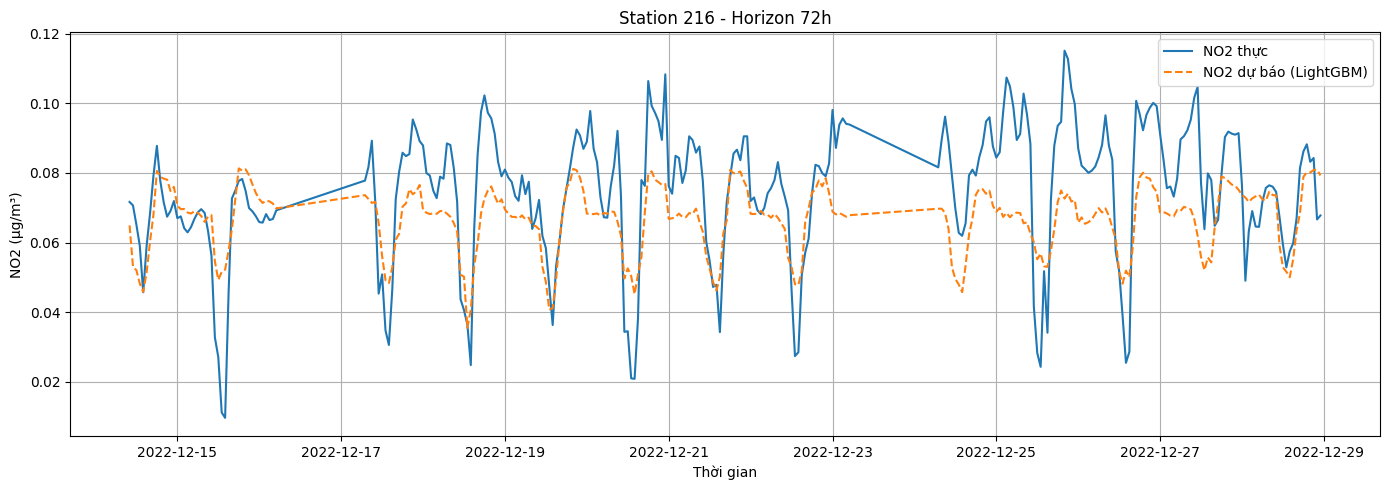

In [13]:
# === Cell 9: Vẽ y_true vs y_pred theo thời gian cho 1 station & 1 horizon ===

def plot_timeseries_example(df_feat, model, horizon_h, station_id,
                            n_points=300):
    # Build dataset
    X, y, meta, feat_cols = build_supervised_for_horizon(df_feat, horizon_h)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = time_based_split(X, y, meta)
    print(y_test)
    
    # Chọn riêng station_id
    mask = (meta_test["station_id"] == station_id)
    print(meta_test)
    print(mask)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    
    if len(X_test_sid) == 0:
        print("Không có mẫu test cho station", station_id)
        return
    
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))
    
    # Chỉ vẽ n_points cuối cho dễ nhìn
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]
    
    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label="NO2 thực", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label="NO2 dự báo (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Thời gian")
    plt.ylabel("NO2 (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ví dụ: vẽ cho trạm 211, horizon = 1
plot_timeseries_example(df_feat, models_by_h[72], horizon_h=72, station_id=216)
